In [1]:
from google.colab import userdata, drive
import os

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast

base_path = "drive/MyDrive/Education/STAT 5330 Project/"
fp = "data/general/user_playthroughs.csv"
path = os.path.join(base_path, fp)

df_users = pd.read_csv(path)
df_users["history"] = df_users["history"].apply(ast.literal_eval)

fp = "data/general/sampled_track_metadata.csv"
path = os.path.join(base_path, fp)
meta_df = pd.read_csv(path)

fp = "data/phase_2/sampled_encoder_transformed_data.csv"
path = os.path.join(base_path, fp)
df = pd.read_csv(path)



In [9]:
print(df_users.shape)
df_users.head()

(1000, 2)


,user_id,history
0,0,"[15208, 33829, 4096, 99394, 13130, 40986, 3382..."
1,1,"[57206, 8374, 29119, 47971, 29119, 56496, 3394..."
2,2,"[72892, 96250, 73593, 18471, 5624, 78993, 217,..."
3,3,"[7986, 69935, 46870, 36692, 69935, 36319, 1532..."
4,4,"[54706, 54760, 42621, 14703, 81940, 47955, 238..."


In [39]:
df_users["history"].apply(len).describe()

,history
count,1000.00000
mean,29109.75200
std,14157.69289
min,5500.00000
25%,18385.00000
50%,26015.50000
75%,37978.50000
max,73408.00000


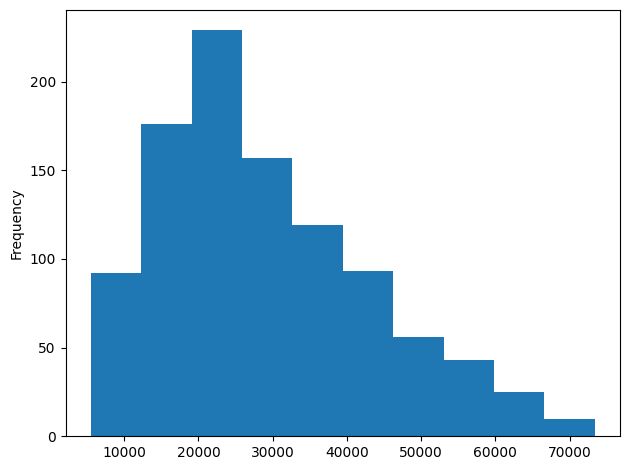

In [38]:
df_users["history"].apply(len).plot(kind="hist")
plt.tight_layout()
plt.show()

In [12]:
print(meta_df.shape)
meta_df.head()

(100000, 7)


,name,album,main_artist,track_number,disc_number,release_date,key
0,Soar,Reboot,Approaching Nirvana,7,1,2014-12-19,5
1,Assanhado,Original Classic Recordings Vol. I,Jacob Do Bandolim,1,1,1991-11-01,4
2,A Tempest in a Teacup,Fingers Crossed,Derek Webb,4,1,2017-09-29,5
3,All Of My Life,What A Wonderful World,Roger Whittaker,4,1,1988-12-06,3
4,playabump,Last Summer : MMXX : Lo-Hop Anthology,Pueblo Vista,20,1,2020-06-08,1


In [13]:
print(df.shape)
df.head()

(100000, 4)


,0,1,2,3
0,2.960553,-0.916769,2.454134,1.319768
1,3.175263,-0.304434,1.246457,-0.875990
2,2.797481,-1.068465,4.120725,0.792351
3,3.640691,-1.455590,3.797172,1.531016
4,8.203306,1.218905,9.064062,5.096675


In [14]:
meta_df_reset = meta_df.reset_index()
df_reset = df.reset_index()

meta_df

,name,album,main_artist,track_number,disc_number,release_date,key
0,Soar,Reboot,Approaching Nirvana,7,1,2014-12-19,5
1,Assanhado,Original Classic Recordings Vol. I,Jacob Do Bandolim,1,1,1991-11-01,4
2,A Tempest in a Teacup,Fingers Crossed,Derek Webb,4,1,2017-09-29,5
3,All Of My Life,What A Wonderful World,Roger Whittaker,4,1,1988-12-06,3
4,playabump,Last Summer : MMXX : Lo-Hop Anthology,Pueblo Vista,20,1,2020-06-08,1
...,...,...,...,...,...,...,...
99995,Virgo prudentissima/Fortuna desperata,Missa L'homme Arme,Ludwig Senfl,3,1,2004-01-01,11
99996,Roll With It,Like I Said,Ani DiFranco,4,1,1993,2
99997,For Once,Beta Love,Ra Ra Riot,5,1,2013-01-22,9
99998,Whatever You Got,Whatever You Got,Niia,1,1,2019-11-22,4


In [15]:
track_feature_matrix = df.to_numpy()
track_feature_matrix.shape

(100000, 4)

In [24]:
def add_user_vectors(user_df, horizons=(50, 500), full_col="vector_f", prefix="vector_"):
    def mean_prefix(x, h):
        if x is None or len(x) == 0:
            return None
        hh = min(h, len(x))
        return x[:hh].mean(axis=0)

    # full-history vector
    user_df[full_col] = user_df["feature_seq"].apply(lambda x: x.mean(axis=0) if len(x) else None)

    # horizon vectors
    for h in horizons:
        user_df[f"{prefix}{h}"] = user_df["feature_seq"].apply(lambda x, h=h: mean_prefix(x, h))

    return user_df


def centroid_distance_stats(U):
    """
    U: (n_users, d)
    """
    c = U.mean(axis=0, keepdims=True)
    dists = np.linalg.norm(U - c, axis=1)
    return {
        "mean": float(dists.mean()),
        "median": float(np.median(dists)),
        "p90": float(np.quantile(dists, 0.9)),
    }


def spread_variance(U):
    return float(U.var(axis=0).mean())


def avg_pairwise_distance(U, max_pairs=100000, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)
    n = U.shape[0]
    a = rng.integers(0, n, size=max_pairs)
    b = rng.integers(0, n, size=max_pairs)
    d = np.linalg.norm(U[a] - U[b], axis=1)
    return float(d.mean())


def drift_stats(U1, U2):
    step = np.linalg.norm(U2 - U1, axis=1)
    return {
        "mean": float(step.mean()),
        "median": float(np.median(step)),
        "p90": float(np.quantile(step, 0.9)),
    }


def evaluate_user_vectors(user_df, vector_cols, rng=None):
    """
    vector_cols: list like ["vector_50", "vector_500", "vector_f"] or any horizons
    Returns a results DataFrame with per-column metrics.
    """
    rows = []
    for col in vector_cols:
        U = np.vstack(user_df[col].values)
        row = {
            "vector_col": col,
            "n_users": U.shape[0],
            "centroid_mean": centroid_distance_stats(U)["mean"],
            "centroid_median": centroid_distance_stats(U)["median"],
            "centroid_p90": centroid_distance_stats(U)["p90"],
            "spread_var": spread_variance(U),
            "avg_pairwise_dist": avg_pairwise_distance(U, rng=rng)
        }
        rows.append(row)

    return pd.DataFrame(rows)


def evaluate_drifts(user_df, vector_cols_in_order):
    rows = []
    for c1, c2 in zip(vector_cols_in_order[:-1], vector_cols_in_order[1:]):
        U1 = np.vstack(user_df[c1].values)
        U2 = np.vstack(user_df[c2].values)
        stats = drift_stats(U1, U2)
        rows.append({
            "from": c1,
            "to": c2,
            "n_users": U1.shape[0],
            "drift_mean": stats["mean"],
            "drift_median": stats["median"],
            "drift_p90": stats["p90"],
        })
    return pd.DataFrame(rows)


def history_to_features(idx_list):
    idx_array = np.array(idx_list)
    return track_feature_matrix[idx_array]



In [25]:
user_df = df_users.copy()

user_df["feature_seq"] = user_df["history"].apply(history_to_features)

user_df = add_user_vectors(user_df, horizons=[50, 500, 2000, 10000])

vector_cols = ["vector_50", "vector_500", "vector_2000", "vector_10000", "vector_f"]
summary_df = evaluate_user_vectors(user_df, vector_cols)
drift_df = evaluate_drifts(user_df, vector_cols_in_order=vector_cols)

In [26]:
summary_df

,vector_col,n_users,centroid_mean,centroid_median,centroid_p90,spread_var,avg_pairwise_dist
0,vector_50,1000,1.963122,1.575449,3.420554,1.541876,2.908364
1,vector_500,1000,1.217002,1.000018,2.210337,0.514883,1.760599
2,vector_2000,1000,1.092048,0.921162,1.888434,0.396141,1.564534
3,vector_10000,1000,1.047580,0.917517,1.750601,0.360576,1.496355
4,vector_f,1000,1.039789,0.908030,1.735436,0.355213,1.485689


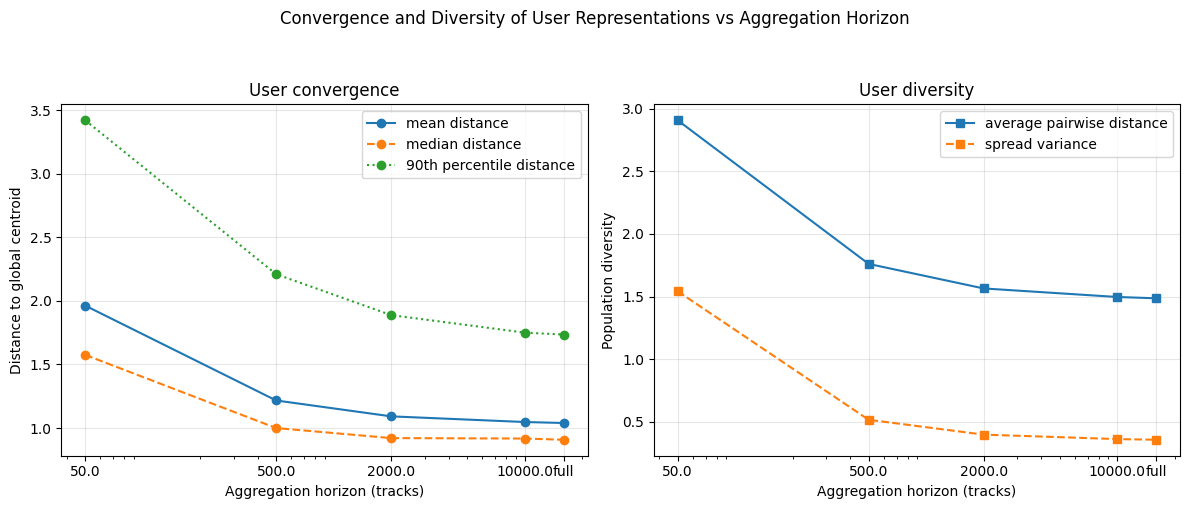

In [60]:
def parse_horizon(vc):
    if vc == "vector_f":
        return None
    return int(vc.split("_")[1])

tmp = summary_df.copy()
tmp["horizon"] = tmp["vector_col"].apply(parse_horizon)

tmp_no_full = tmp[tmp["vector_col"] != "vector_f"].sort_values("horizon")
tmp_full    = tmp[tmp["vector_col"] == "vector_f"]

x_base = tmp_no_full["horizon"].to_list()
x_full = x_base[-1] * 1.6

x = x_base + [x_full]
x_labels = [str(h) for h in x_base] + ["full"]

# ---- metrics ----
centroid_mean   = tmp_no_full["centroid_mean"].to_list()   + tmp_full["centroid_mean"].to_list()
centroid_median = tmp_no_full["centroid_median"].to_list() + tmp_full["centroid_median"].to_list()
centroid_p90    = tmp_no_full["centroid_p90"].to_list()    + tmp_full["centroid_p90"].to_list()

avg_pairwise = tmp_no_full["avg_pairwise_dist"].to_list() + tmp_full["avg_pairwise_dist"].to_list()
spread_var   = tmp_no_full["spread_var"].to_list()        + tmp_full["spread_var"].to_list()

# ---- plot ----
fig, axes = plt.subplots(1, 2, figsize=(12, 4.8), sharex=True)

clean_labels = [str(h) for h in x_base] + ["full"]

# ---- Left panel: centroid distance ----
ax = axes[0]
ax.plot(x, centroid_mean, marker="o", label="mean distance")
ax.plot(x, centroid_median, marker="o", linestyle="--", label="median distance")
ax.plot(x, centroid_p90, marker="o", linestyle=":", label="90th percentile distance")
ax.set_xscale("log")
ax.set_xticks(x)
ax.set_xticklabels(clean_labels)
ax.set_xlabel("Aggregation horizon (tracks)")
ax.set_ylabel("Distance to global centroid")
ax.set_title("User convergence")
ax.grid(alpha=0.3)
ax.legend()

# ---- Right panel: diversity ----
ax = axes[1]
ax.plot(x, avg_pairwise, marker="s", label="average pairwise distance")
ax.plot(x, spread_var, marker="s", linestyle="--", label="spread variance")
ax.set_xscale("log")
ax.set_xticks(x)
ax.set_xticklabels(clean_labels)
ax.set_xlabel("Aggregation horizon (tracks)")
ax.set_ylabel("Population diversity")
ax.set_title("User diversity")
ax.grid(alpha=0.3)
ax.legend()

plt.suptitle("Convergence and Diversity of User Representations vs Aggregation Horizon", y=1.05)
plt.tight_layout()
plt.show()


In [52]:
drift_df

,from,to,n_users,drift_mean,drift_median,drift_p90
0,vector_50,vector_500,1000,1.674635,1.356697,3.281663
1,vector_500,vector_2000,1000,0.486146,0.367458,0.912771
2,vector_2000,vector_10000,1000,0.261021,0.205044,0.492173
3,vector_10000,vector_f,1000,0.094526,0.072078,0.199763


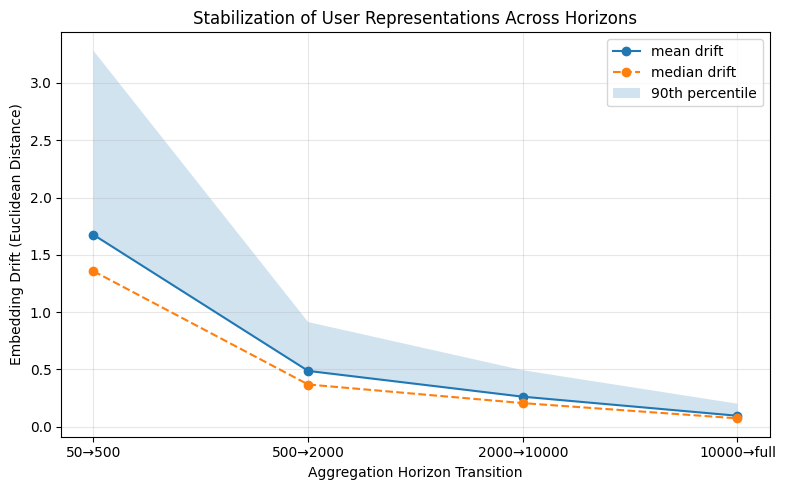

In [53]:
transitions = ["50→500", "500→2000", "2000→10000", "10000→full"]

mean_drift   = drift_df["drift_mean"].values
median_drift = drift_df["drift_median"].values
p90_drift    = drift_df["drift_p90"].values

plt.figure(figsize=(8,5))

plt.plot(transitions, mean_drift, marker="o", label="mean drift")
plt.plot(transitions, median_drift, marker="o", linestyle="--", label="median drift")

plt.fill_between(
    transitions,
    mean_drift,
    p90_drift,
    alpha=0.2,
    label="90th percentile"
)

plt.ylabel("Embedding Drift (Euclidean Distance)")
plt.xlabel("Aggregation Horizon Transition")
plt.title("Stabilization of User Representations Across Horizons")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [28]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = np.vstack(user_df["vector_f"].values)

In [29]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
X_2d = tsne.fit_transform(X)

In [30]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X)

user_df["cluster"] = clusters


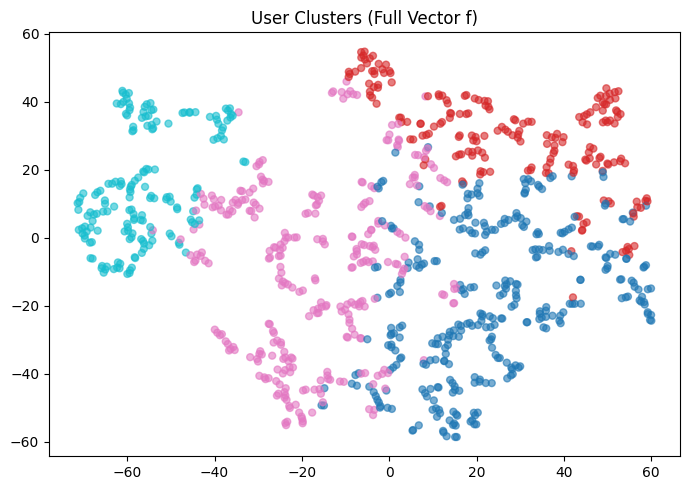

In [31]:
plt.figure(figsize=(7,5))
plt.scatter(X_2d[:,0], X_2d[:,1], c=clusters, s=25, alpha= 0.6, cmap="tab10")
plt.title("User Clusters (Full Vector)")

# for i, (x, y) in enumerate(X_2d):
#     plt.text(x+0.02, y+0.02, str(i), fontsize=8)  # label users
plt.tight_layout()
plt.show()


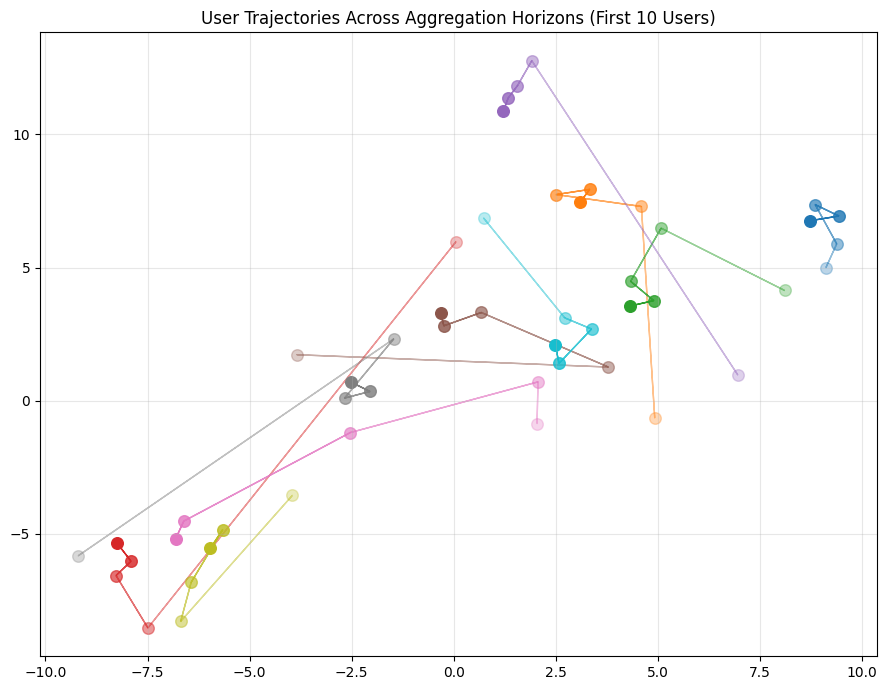

In [35]:
# -----------------------------
# CONFIG
# -----------------------------
N = 10  # number of users to plot
vector_cols = [
    "vector_50",
    "vector_500",
    "vector_2000",
    "vector_10000",
    "vector_f"
]

alpha_vals = np.linspace(0.3, 1.0, len(vector_cols))  # light → dark

V_list = []
for col in vector_cols:
    V_list.append(np.vstack(user_df[col].values[:N]))

V_all = np.vstack(V_list)  # shape: (N * H, d)

tsne = TSNE(
    n_components=2,
    perplexity=10,
    random_state=42,
    init="pca"
)
V2d = tsne.fit_transform(V_all)

# split back by horizon
H = len(vector_cols)
V2d_split = [
    V2d[i*N:(i+1)*N] for i in range(H)
]

plt.figure(figsize=(9, 7))

colors = plt.cm.tab10(np.linspace(0, 1, N))  # one color per user

for i in range(N):
    base_color = colors[i]

    # plot points and arrows across horizons
    for h in range(H):
        c = (*base_color[:3], alpha_vals[h])
        plt.scatter(
            V2d_split[h][i, 0],
            V2d_split[h][i, 1],
            color=c,
            s=70
        )

        # arrow to next horizon
        if h < H - 1:
            dx = V2d_split[h+1][i, 0] - V2d_split[h][i, 0]
            dy = V2d_split[h+1][i, 1] - V2d_split[h][i, 1]

            plt.arrow(
                V2d_split[h][i, 0],
                V2d_split[h][i, 1],
                dx,
                dy,
                color=(*base_color[:3], alpha_vals[h+1]),
                head_width=0.015,
                length_includes_head=True,
                linewidth=1
            )

plt.title(f"User Trajectories Across Aggregation Horizons (First {N} Users)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
